In [41]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import Activation, LeakyReLU, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import Sequence
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(gpu_devices))
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs: 1


Define paths

In [42]:
base_path = os.path.join("/mnt", "g", "Yerb", "guayaki")
train_path = os.path.join(base_path, "train", "labeled")
validation_path = os.path.join(base_path, "validation", "labeled")
csv_path = os.path.join("data", "files.csv")

Define all possible classes

In [43]:
classes = ["Cans", "Cans/Enlightenmint", "Cans/Revelberry", "Cans/Bluephoria", "Cans/Lemon", "Cans/Slim", "Cans/Slim/Gold", "Cans/Slim/Cranpom", "Cans/Slim/Blackberry", "Cans/Slim/Other", "Cans/Slim/GrapefruitGinger", "Cans/Slim/LimaLimon", "Cans/Other", "Bottles", "Bottles/Mint", "Bottles/Raspberry", "Bottles/Original", "Bottles/Passion", "Bottles/Other", "NoYerb"]
#classes_merged = ["Bottles", "Cans", "Cans/Slim"]
classes_merged = ["Cans", "Cans/Enlightenmint", "Cans/Revelberry", "Cans/Bluephoria", "Cans/Lemon", "Cans/Slim", "Cans/Slim/Gold", "Cans/Slim/Cranpom", "Cans/Slim/Blackberry", "Cans/Slim/Other", "Cans/Slim/GrapefruitGinger", "Cans/Slim/LimaLimon", "Cans/Other", "Bottles", "Bottles/Mint", "Bottles/Raspberry", "Bottles/Original", "Bottles/Passion", "Bottles/Other", "NoYerb"]
num_classes = len(classes)
num_classes_merged = len(classes_merged)

Define hyperparameters and input shape

In [44]:
validation_split = 0.15
img_width, img_height = 256, 256
batch_size = 32
lr = 0.0001

Perform our train/validation split

In [45]:
# Only split if our validation folder is empty (useful for retraining models)
if (len(os.listdir(validation_path)) == 0):
    for filename in os.listdir(base_path):
        # Leave folders alone
        if(filename == "train" or filename == "validation"):
            continue

        try:
            if np.random.rand() < validation_split:
                os.rename(os.path.join(base_path, filename), os.path.join(validation_path, filename))
            else:
                os.rename(os.path.join(base_path, filename), os.path.join(train_path, filename))
        except:
            pass

Assign base classes to the training data (as covered in the readme) and multi-hot encode them

In [46]:
class_list_augmented = [] # Bad global, used to pass the results to the code that calculates class weight
def generate_labels_from_csv(df):
    # Remove the url from each filename
    df['Filename'] = [filename.split('/')[-1] for filename in df['Filename']]
    # Create a dictionary with the filename as the key a list of its classes as the value
    class_dict = dict(zip(df['Filename'], [label.split(',') for label in df['Label']]))

    # Create a list of the classes in the same order as the images
    class_lists = [class_dict[filename] for filename in df['Filename'].tolist()]
    
    # Assign base classes
    for class_list in class_lists:
        augmented_list = set(class_list)
        for label in class_list:
            if label.startswith("Cans"):
                augmented_list.add("Cans")
                if label.startswith("Cans/Slim"):
                    augmented_list.add("Cans/Slim")
            elif label.startswith("Bottles"):
                augmented_list.add("Bottles")
        class_list_augmented.append(list(augmented_list))

    # Merge classes into cans, slim cans, bottles, and no yerb
    # for class_list in class_lists:
    #     augmented_list = []
    #     for label in class_list:
    #         if label.startswith("Cans"):
    #             augmented_list.append("Cans")
    #             if label.startswith("Cans/Slim"):
    #                 augmented_list.append("Cans/Slim")
    #         elif label.startswith("Bottles"):
    #             augmented_list.append("Bottles")
    #     class_list_augmented.append(sorted(list(set(augmented_list))))

    # Convert the classes to ints
    Y = [[classes_merged.index(label) for label in image_labels] for image_labels in class_list_augmented]

    # Multi-hot encode the classes
    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(Y)

    # Save the filenames and labels in a dictionary
    return dict(zip(df['Filename'], Y))

Define the data generator to load and normalize images in a format Keras recognises. This is used since Keras doesn't have great support for multiclass image loading

In [47]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras. If augment=True, half of each batch is augmented images (random rotation and translation), the other half is the original images'
    def __init__(self, img_path, labels, batch_size=32, target_size=(512,512), n_channels=3, n_classes=10, shuffle=True, augment=False):
        'Initialization'
        self.img_path = img_path
        self.img_list = os.listdir(img_path) # Usable images for training/validation
        self.labels = labels
        self.target_size = target_size
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.img_list))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.augment:
            return int(np.floor(len(self.img_list) / self.batch_size)*2)
        return int(np.floor(len(self.img_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indices of the batch
        if self.augment:
            chosen_indices = self.indices[int(np.floor((index*self.batch_size/2))):int(np.floor((index+1)*self.batch_size/2))]
        else:
            chosen_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Load batch_size images and labels
        return self.__data_generation(chosen_indices)

    def on_epoch_end(self):
        'Updates indices after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, indicies):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size, *self.target_size, self.n_channels))
        y = np.zeros((self.batch_size, num_classes_merged), dtype=bool)

        if self.augment:
            image_range = range(0, self.batch_size, 2)
        else:
            image_range = range(self.batch_size)

        for image_id, it in zip(indicies, image_range):
            # Read the image in as [height, width, n_channels]
            img = Image.open(os.path.join(self.img_path, self.img_list[image_id]))

            # Resize the image to the target size
            img = img.resize(self.target_size, resample=Image.BILINEAR)
            img_np = np.asarray(img)
            # Release our lock on the file
            img.close()
            
            # Reshape to [n_channels, height, width] if necessary
            if keras.backend.image_data_format() == 'channels_first':
                img_np = np.transpose(img_np, (2, 0, 1))

            # Normalize the image to [-1,1]
            img_np = img_np / 127.5 - 1

            if self.augment:
                # Apply random rotation and translation
                img_aug = img_np.copy()
                img_aug = cv2.rotate(img_aug, np.random.choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]))
                img_aug = cv2.warpAffine(img_aug, np.float32([[1,0,np.random.randint(-20,20)],[0,1,np.random.randint(-20,20)]]), (img_aug.shape[1], img_aug.shape[0]))
                
                X[it] = img_np
                X[it+1] = img_aug
                y[it] = self.labels[self.img_list[image_id]]
                y[it+1] = self.labels[self.img_list[image_id]]
            else:
                X[it] = img_np
                y[it] = self.labels[self.img_list[image_id]]
            
        return X, y

Create train and test image generators from these classes

In [48]:
labels = generate_labels_from_csv(pd.read_csv(csv_path))
train_ds = DataGenerator(
    img_path=train_path,
    labels=labels,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    shuffle=True,
    augment=True)

validation_ds = DataGenerator(
    img_path=validation_path,
    labels=labels,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    shuffle=True,
    augment=False)

Compute class weights as our dataset is very imbalanced

In [49]:
# Compute class weights
class_list_np = np.array(class_list_augmented, dtype=object)
# Collapse the list of lists into a single list
class_list_np = np.concatenate(class_list_np)

#class_weight_array = compute_class_weight(class_weight='balanced', classes=classes, y=class_list_np)
class_weight_array = compute_class_weight(class_weight='balanced', classes=classes_merged, y=class_list_np)
class_weights = dict(enumerate(class_weight_array))

Generate some samples to make sure everything matches up

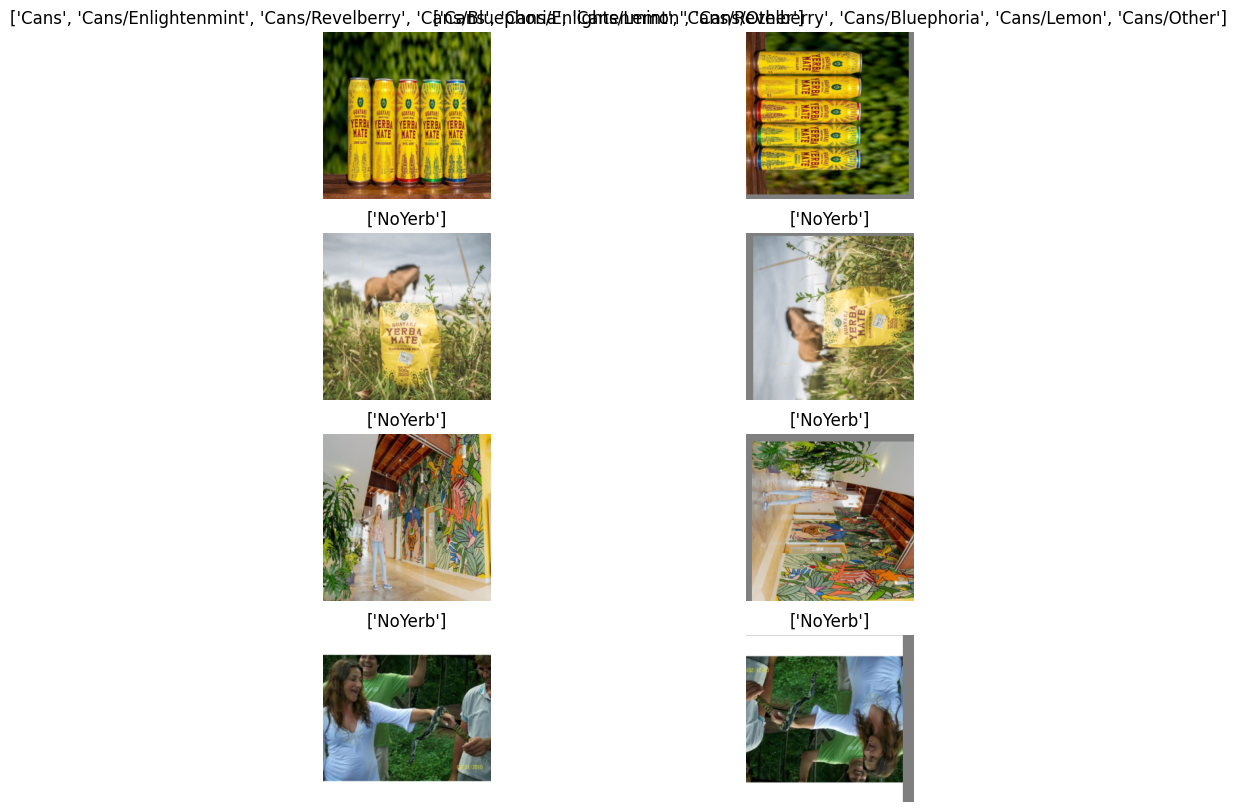

In [50]:
# Use matplotlib to print some examples from train_ds.
# Large spacing between images
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
images, labels = train_ds.__getitem__(np.random.randint(0, len(train_ds)))
for j in range(2):
    for i in range(4):
        # New image every time
        ax[i, j].imshow((images[2*i+j]+ 1)/2)
        # Convert the one hot array back to text
        label_text = [classes_merged[u] for u, label in enumerate(labels[2*i+j]) if label == 1]
        ax[i, j].set_title(label_text)
        ax[i, j].axis('off')
plt.show()

Define the CNN. For multi-hot encoded data we use sigmoid as our final activation function instead of softmax. https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification

In [51]:
if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False) 

# Freeze the base model
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes_merged))

model.compile(loss='binary_crossentropy',
              #optimizer=SGD(learning_rate=lr, momentum=0.9),
              optimizer=Adam(learning_rate=lr),
              #optimizer='rmsprop',
              metrics=['accuracy'])


Fit using our class weights from earlier

In [52]:
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
tensorboard = callbacks.TensorBoard(log_dir=f'./logs/run{np.random.randint(1,1000)}', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=5)
model.fit(train_ds,
        batch_size=batch_size,
        epochs=50,
        callbacks=[early_stopping],
        validation_data=validation_ds,
        class_weight=class_weights,
        use_multiprocessing=True,
        workers=40)

Epoch 1/50
312/312 [==============================] - 76s 227ms/step - loss: 0.1595 - accuracy: 0.3036 - val_loss: 0.4289 - val_accuracy: 0.4364
Epoch 2/50
312/312 [==============================] - 72s 217ms/step - loss: 0.1281 - accuracy: 0.3345 - val_loss: 0.3651 - val_accuracy: 0.4208
Epoch 3/50
312/312 [==============================] - 84s 255ms/step - loss: 0.1146 - accuracy: 0.4425 - val_loss: 0.3767 - val_accuracy: 0.5078
Epoch 4/50
312/312 [==============================] - 83s 252ms/step - loss: 0.1249 - accuracy: 0.3461 - val_loss: 0.4861 - val_accuracy: 0.1429
Epoch 5/50
312/312 [==============================] - 85s 260ms/step - loss: 0.1239 - accuracy: 0.4582 - val_loss: 0.3813 - val_accuracy: 0.4721
Epoch 6/50
312/312 [==============================] - 83s 253ms/step - loss: 0.1117 - accuracy: 0.4928 - val_loss: 0.3737 - val_accuracy: 0.4810
Epoch 7/50
312/312 [==============================] - 86s 261ms/step - loss: 0.1078 - accuracy: 0.5215 - val_loss: 0.3609 - val_ac

Evaluate the model (check validation set imbalance)

28/28 [==============================] - 3s 72ms/step
Class Cans count: 236.0
Class Cans F1 Score: 0.6313253012048193
Class Cans Precision: 0.7318435754189944
Class Cans Recall: 0.5550847457627118


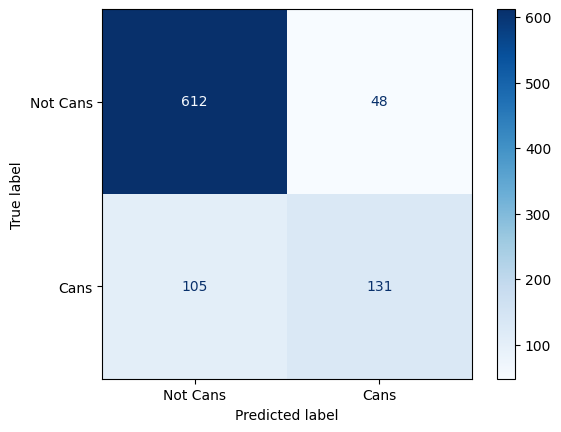

Class Cans/Enlightenmint count: 67.0
Class Cans/Enlightenmint F1 Score: 0.21505376344086022
Class Cans/Enlightenmint Precision: 0.38461538461538464
Class Cans/Enlightenmint Recall: 0.14925373134328357


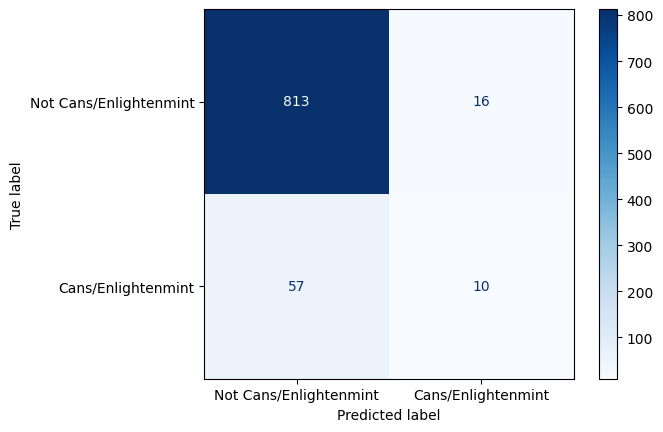

Class Cans/Revelberry count: 48.0
Class Cans/Revelberry F1 Score: 0.039999999999999994
Class Cans/Revelberry Precision: 0.5
Class Cans/Revelberry Recall: 0.020833333333333332


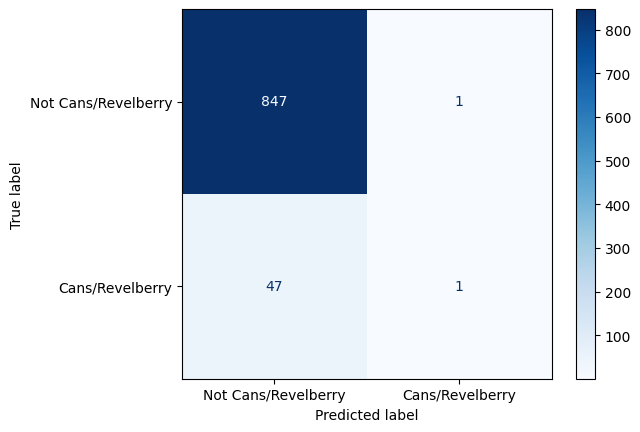

Class Cans/Bluephoria count: 41.0
Class Cans/Bluephoria F1 Score: 0.038461538461538464
Class Cans/Bluephoria Precision: 0.09090909090909091
Class Cans/Bluephoria Recall: 0.024390243902439025


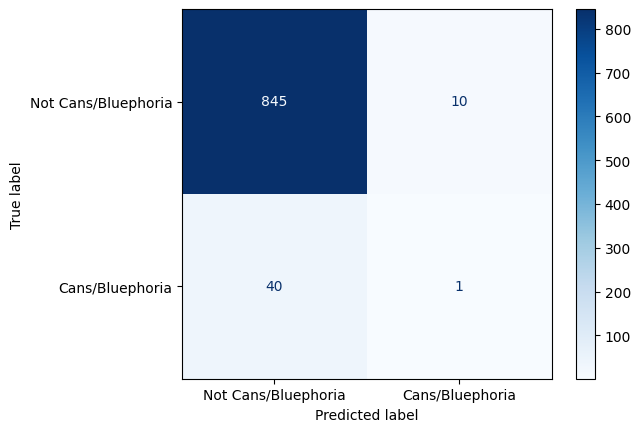

Class Cans/Lemon count: 34.0
Class Cans/Lemon F1 Score: 0.0
Class Cans/Lemon Precision: 0.0
Class Cans/Lemon Recall: 0.0


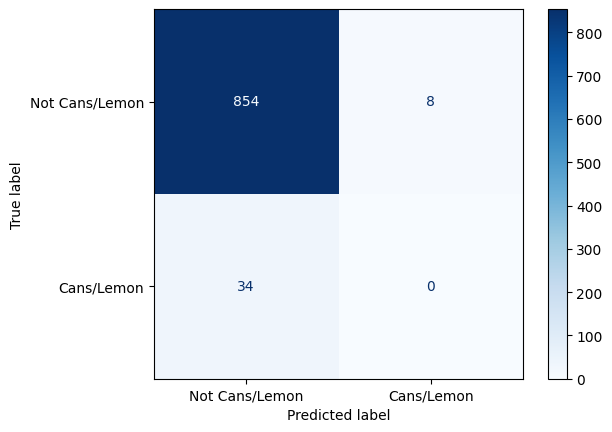

Class Cans/Slim count: 85.0
Class Cans/Slim F1 Score: 0.2162162162162162
Class Cans/Slim Precision: 0.46153846153846156
Class Cans/Slim Recall: 0.1411764705882353


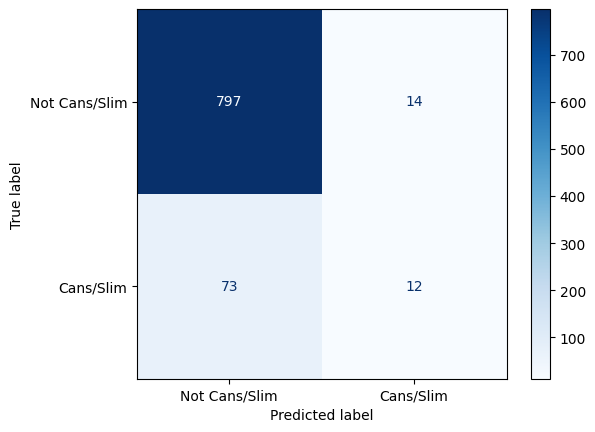

Class Cans/Slim/Gold count: 30.0
Class Cans/Slim/Gold F1 Score: 0.0
Class Cans/Slim/Gold Precision: 0.0
Class Cans/Slim/Gold Recall: 0.0


/home/finn/YerbClassifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


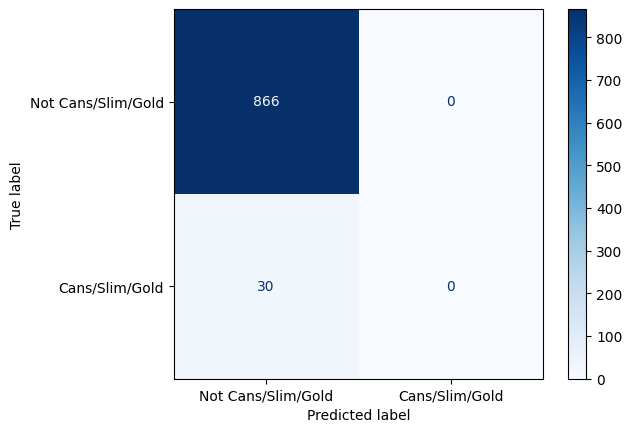

Class Cans/Slim/Cranpom count: 31.0
Class Cans/Slim/Cranpom F1 Score: 0.06060606060606061
Class Cans/Slim/Cranpom Precision: 0.5
Class Cans/Slim/Cranpom Recall: 0.03225806451612903


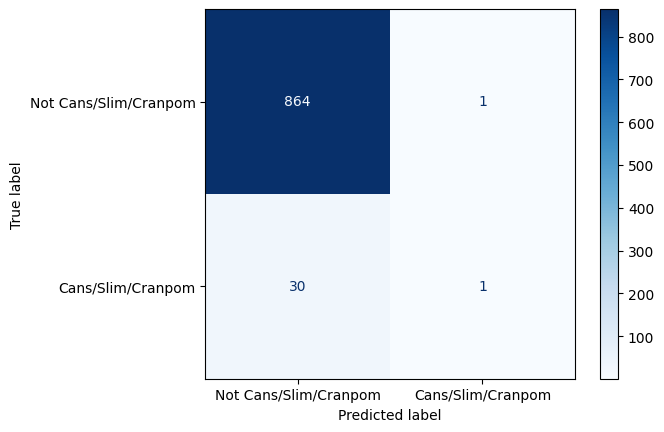

Class Cans/Slim/Blackberry count: 10.0
Class Cans/Slim/Blackberry F1 Score: 0.0
Class Cans/Slim/Blackberry Precision: 0.0
Class Cans/Slim/Blackberry Recall: 0.0


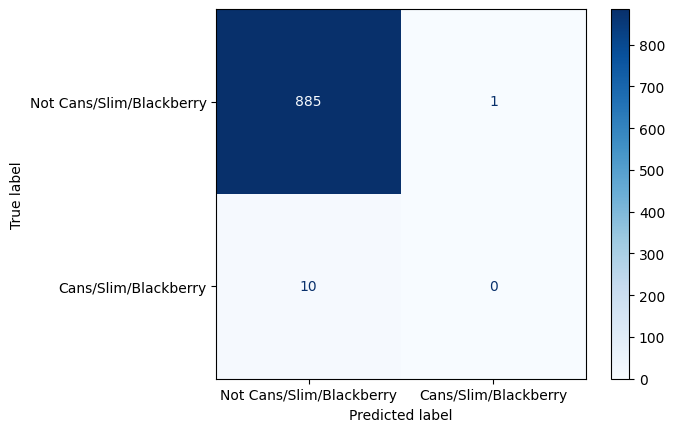

Class Cans/Slim/Other count: 4.0
Class Cans/Slim/Other F1 Score: 0.0
Class Cans/Slim/Other Precision: 0.0
Class Cans/Slim/Other Recall: 0.0


/home/finn/YerbClassifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


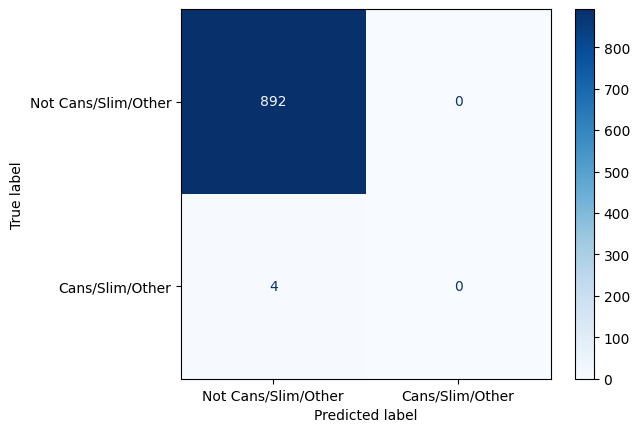

Class Cans/Slim/GrapefruitGinger count: 23.0
Class Cans/Slim/GrapefruitGinger F1 Score: 0.12903225806451613
Class Cans/Slim/GrapefruitGinger Precision: 0.25
Class Cans/Slim/GrapefruitGinger Recall: 0.08695652173913043


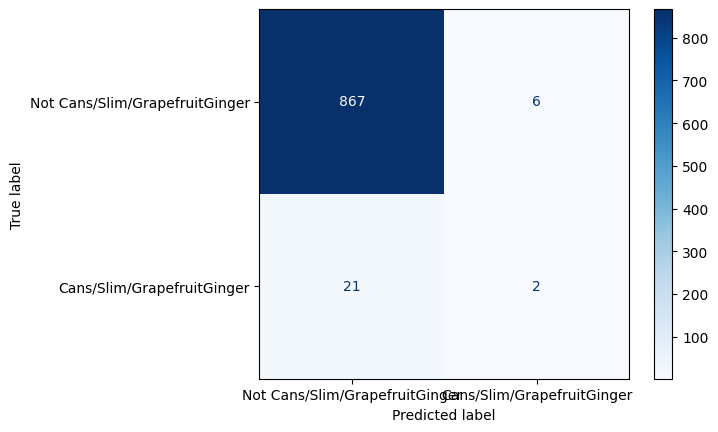

Class Cans/Slim/LimaLimon count: 12.0
Class Cans/Slim/LimaLimon F1 Score: 0.0
Class Cans/Slim/LimaLimon Precision: 0.0
Class Cans/Slim/LimaLimon Recall: 0.0


/home/finn/YerbClassifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


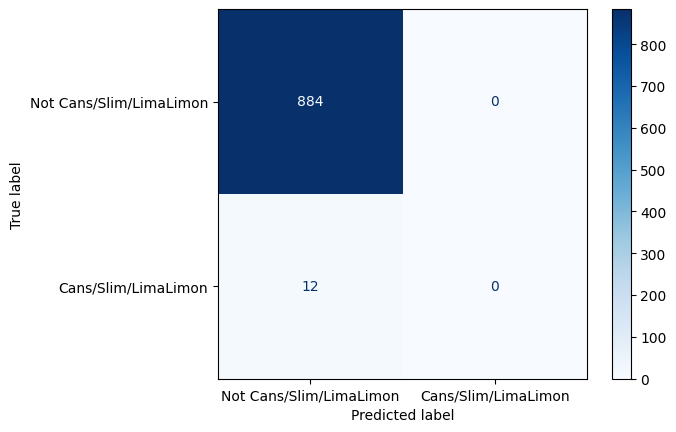

Class Cans/Other count: 24.0
Class Cans/Other F1 Score: 0.07142857142857142
Class Cans/Other Precision: 0.25
Class Cans/Other Recall: 0.041666666666666664


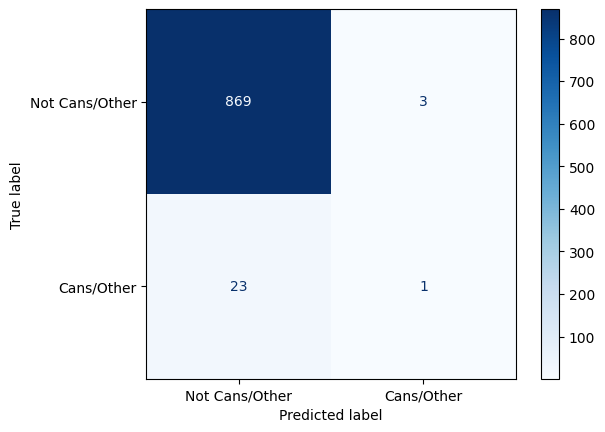

Class Bottles count: 86.0
Class Bottles F1 Score: 0.36363636363636365
Class Bottles Precision: 0.5217391304347826
Class Bottles Recall: 0.27906976744186046


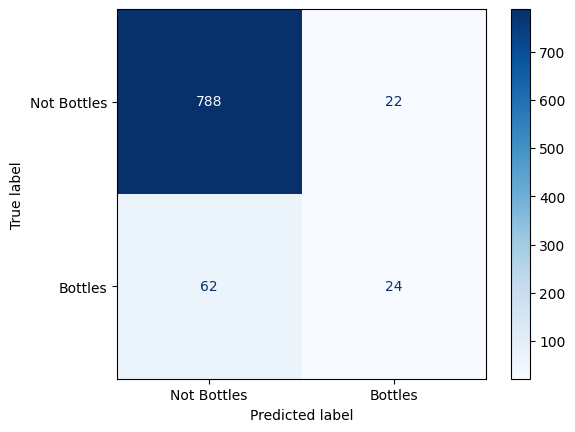

Class Bottles/Mint count: 27.0
Class Bottles/Mint F1 Score: 0.07142857142857142
Class Bottles/Mint Precision: 1.0
Class Bottles/Mint Recall: 0.037037037037037035


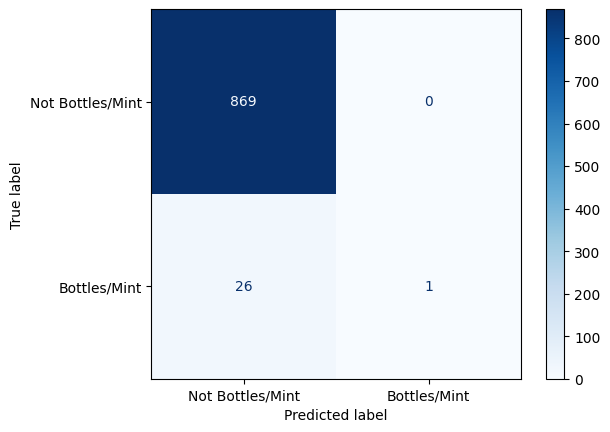

Class Bottles/Raspberry count: 17.0
Class Bottles/Raspberry F1 Score: 0.0
Class Bottles/Raspberry Precision: 0.0
Class Bottles/Raspberry Recall: 0.0


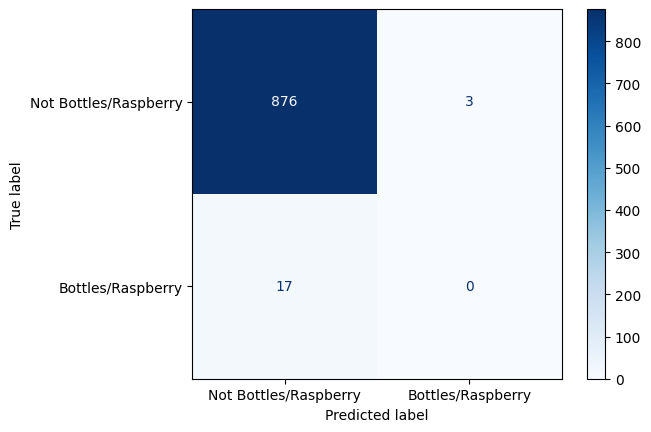

Class Bottles/Original count: 12.0
Class Bottles/Original F1 Score: 0.14285714285714285
Class Bottles/Original Precision: 0.5
Class Bottles/Original Recall: 0.08333333333333333


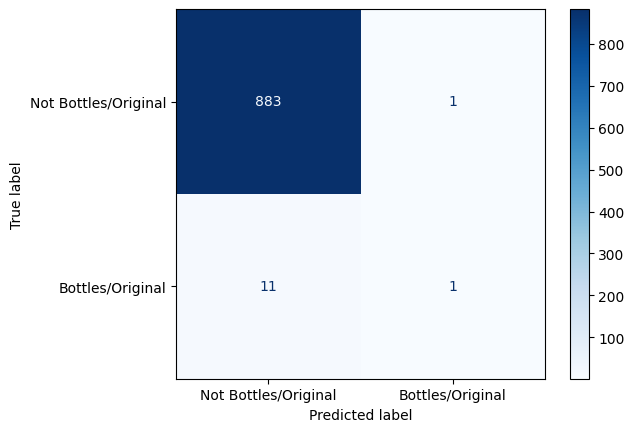

Class Bottles/Passion count: 13.0
Class Bottles/Passion F1 Score: 0.0
Class Bottles/Passion Precision: 0.0
Class Bottles/Passion Recall: 0.0


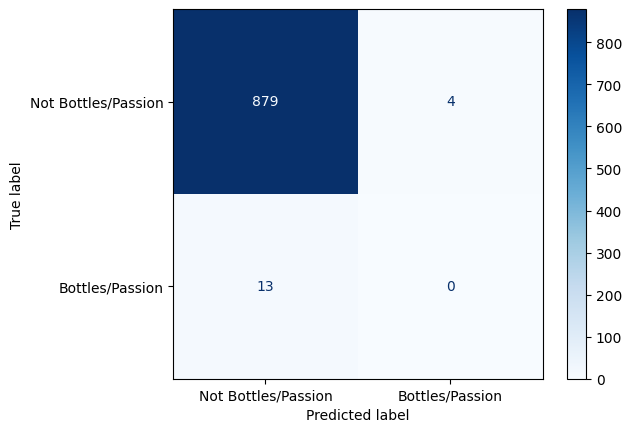

Class Bottles/Other count: 18.0
Class Bottles/Other F1 Score: 0.0
Class Bottles/Other Precision: 0.0
Class Bottles/Other Recall: 0.0


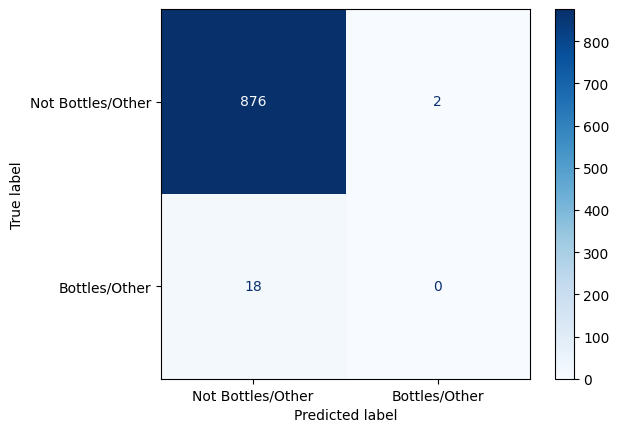

Class NoYerb count: 593.0
Class NoYerb F1 Score: 0.7711069418386493
Class NoYerb Precision: 0.86892177589852
Class NoYerb Recall: 0.6930860033726813


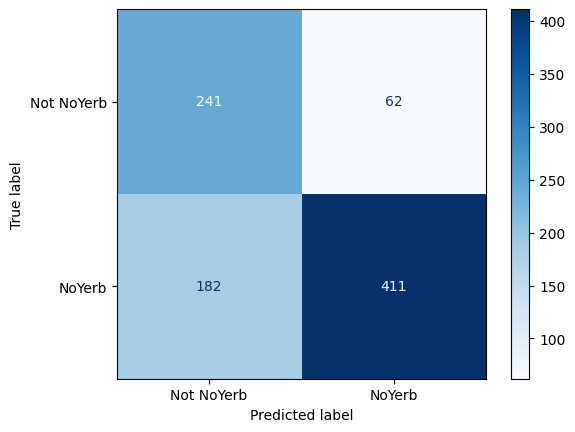

In [53]:
# Get all validation instances into a single array
validation_images = np.empty((len(validation_ds), batch_size, img_width, img_height, 3))
validation_labels = np.empty((len(validation_ds), batch_size, num_classes_merged))
for i in range(len(validation_ds)):
    images, labels = validation_ds.__getitem__(i)
    validation_images[i] = images
    validation_labels[i] = labels
# Remove batch dimension
validation_images = np.reshape(validation_images, (len(validation_ds)*batch_size, img_width, img_height, 3))
validation_labels = np.reshape(validation_labels, (len(validation_ds)*batch_size, num_classes_merged))

# Count the number of each class in the validation set
validation_class_counts = np.sum(validation_labels, axis=0)    

class_balance = validation_class_counts/len(validation_labels)

# Create a confusion matrix
predictions = model.predict(validation_images) > 0.5
predictions = np.round(predictions)

f1_scores = []
precision_scores = []
recall_scores = []
for c in classes_merged:
    print(f'Class {c} count: {validation_class_counts[classes_merged.index(c)]}')
    # F1 Score
    f1_scores.append(f1_score(validation_labels[:,classes_merged.index(c)].tolist(), predictions[:,classes_merged.index(c)].tolist()))
    print(f'Class {c} F1 Score: {f1_scores[-1]}')
    # Precision
    precision_scores.append(precision_score(validation_labels[:,classes_merged.index(c)].tolist(), predictions[:,classes_merged.index(c)].tolist()))
    print(f'Class {c} Precision: {precision_scores[-1]}')
    # Recall
    recall_scores.append(recall_score(validation_labels[:,classes_merged.index(c)].tolist(), predictions[:,classes_merged.index(c)].tolist()))
    print(f'Class {c} Recall: {recall_scores[-1]}')

    cfm = confusion_matrix(validation_labels[:,classes_merged.index(c)].tolist(), predictions[:,classes_merged.index(c)].tolist())
    disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=[f'Not {c}', c])
    disp.plot(cmap='Blues')
    plt.show()

print("Average F1 Score: ", np.mean(f1_scores))
print("Average Precision: ", np.mean(precision_scores))
print("Average Recall: ", np.mean(recall_scores))
